# Import required libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mdshare
import pyemma
import deeptime as dt
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

## Using mdshare, fetch the data from the remote file ‘5d-folding.npy’. This is a system consisting of a single point moving in a 5-dimensional space, but whose behaviour depends only on its euclidean norm, or distance of the point from the center.

In [3]:
# mdshare.fetch didn't work for us somehow -> Error: no match in repo 
data = np.load("5d-folding.npy")

In [4]:
print("Data_Shape:", data.shape)

Data_Shape: (100001, 5)


In [5]:
def eucl_norm(data, i):
    return (data[i,0]**2+data[i,1]**2+data[i,2]**2+data[i,3]**2+data[i,4]**2)**(1/5)

In [6]:
distances= []
for i in range(len(data[:,0])):
    distances.append(eucl_norm(data,i))

In [7]:
print("length of distances:", len(distances))

length of distances: 100001


## Defining an initial model 

### Defining the hyper parameters for the VAMP net

In [79]:
# Tau, how much is the timeshift of the two datasets
tau = 10

# Batch size for Stochastic Gradient descent
batch_size = 3000 

# Which trajectory points percentage is used as validation
val_ratio = 0.1

# How many hidden layers the network has
network_depth = 6 # is defined in lobe below

# "Width" of every layer
layer_width = 20 # is defined in lobe below

# Learning rate used for the ADAM optimizer
learning_rate = 1e-3 

# How many output states the network has
output_size = 6

# Iteration over the training set in the fitting process;
# basically how many iterations our training algorithm will do
nb_epoch = 20

In [80]:
dataset = dt.data.TimeLaggedDataset.from_trajectory(lagtime=tau, data=data.astype(np.float32))

# Number of validation data points 
n_val = int(len(dataset)*val_ratio)
# actual splitting of the dataset
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

from deeptime.util.torch import MLP
lobe = MLP(units=[data.shape[1], 20, 20, 20, 20, output_size], nonlinearity=nn.ReLU, output_nonlinearity=nn.Softmax)
# here we use the retified linear unit as a nonlinearity for processing the layer outputs
# the final output is piped though a softmax function which is 
# a generalized logistic function which ensures positive output values 
# -> good to interpret as a probability

vampnet = dt.decomposition.deep.VAMPNet(lobe=lobe, learning_rate=learning_rate)
# projects data onto dominant slow processes 

from torch.utils.data import DataLoader

loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

In [81]:
model = vampnet.fit(loader_train, n_epochs=nb_epoch, validation_loader=loader_val, progress=tqdm).fetch_model()

VAMPNet epoch:   0%|          | 0/20 [00:00<?, ?it/s]

/home/ferdinand/anaconda3/envs/workshop/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [82]:
transformed_data = model.transform(data)

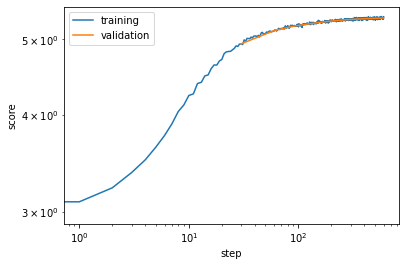

In [83]:
plt.loglog(*vampnet.train_scores.T, label='training') #output 5 at tau 1
plt.loglog(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend();

/home/ferdinand/anaconda3/envs/workshop/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


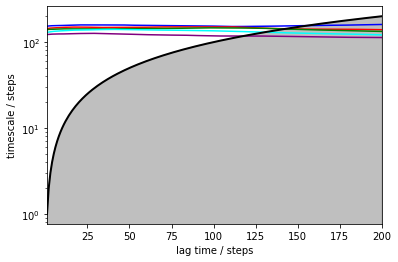

In [84]:
lagtimes = np.arange(1, 201) #output 5 at tau 1
timescales = []
for lag in lagtimes:
    estimator = dt.decomposition.VAMP(lagtime=lag, observable_transform=model)
    vamp_model = estimator.fit(data).fetch_model()
    timescales.append(vamp_model.timescales())
pyemma.plots.plot_implied_timescales((lagtimes, timescales));

## Getting a first feeling for the data

In [85]:
def speed(distances,i):
    return abs((distances[i+1]-distances[i]))

In [86]:
speeds=[]
for i in range(len(distances)-1):
    speeds.append(speed(distances,i))
    
speeds.insert(0,0)

Text(0, 0.5, 'speed')

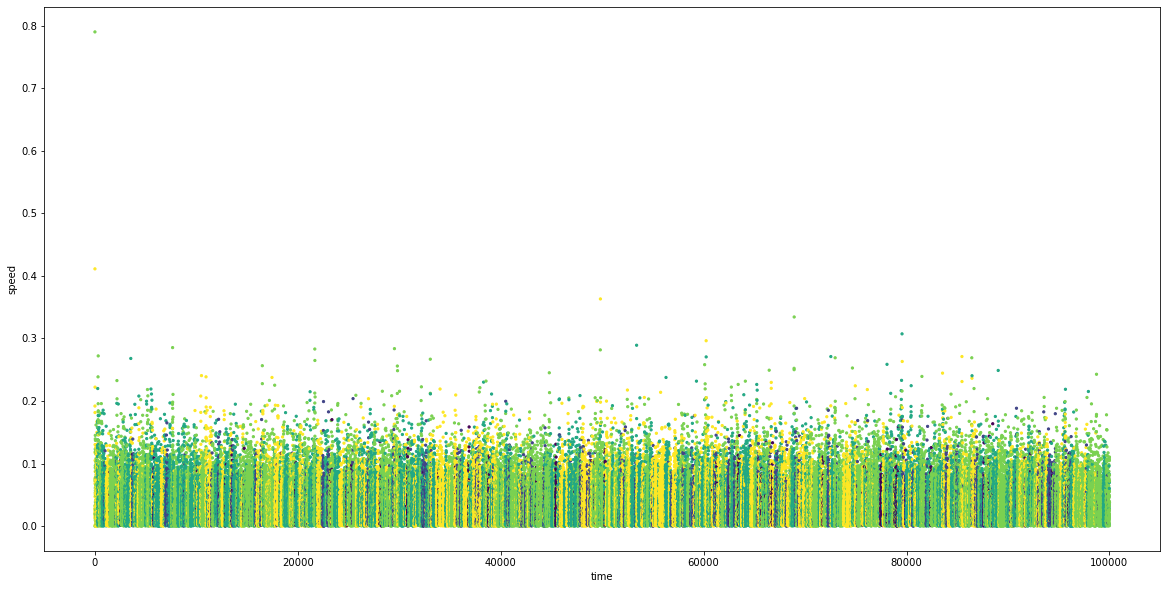

In [87]:
plt.figure(figsize=(20,10))
plt.scatter(np.arange(0,100001), speeds, c=np.argmax(transformed_data, axis=1), s=5)
plt.xlabel('time')
plt.ylabel('speed')

Text(0, 0.5, 'speed')

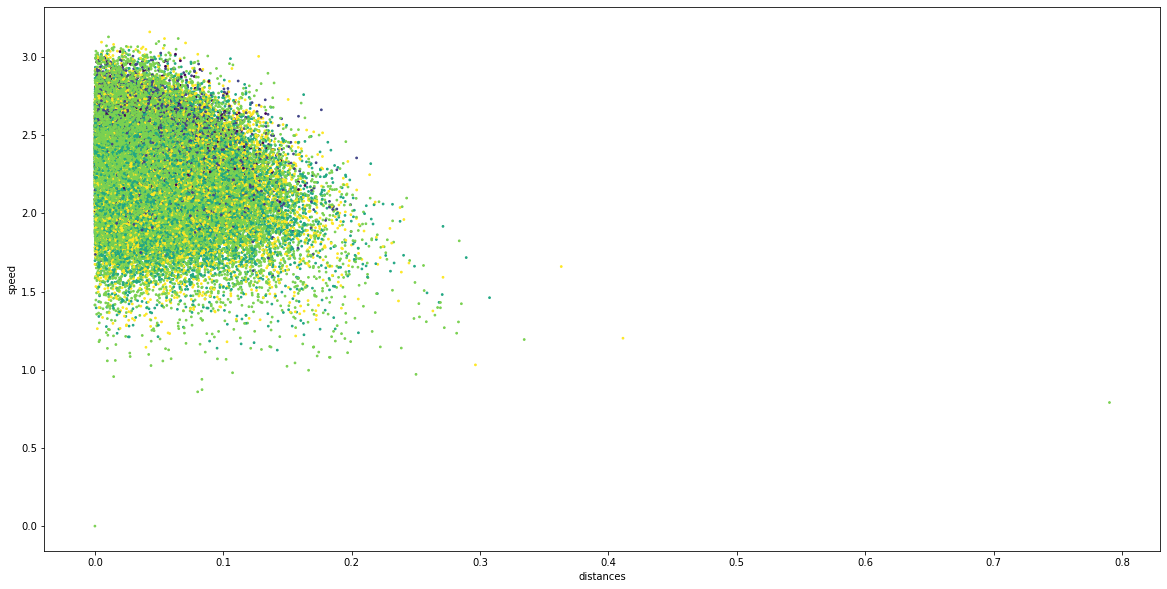

In [88]:
plt.figure(figsize=(20,10))
plt.scatter(speeds, distances, c=np.argmax(transformed_data, axis=1), s=3)
plt.xlabel('distances')
plt.ylabel('speed')

In [23]:
transformed_data_initial_10_1 = model.transform(data)

/home/ferdinand/anaconda3/envs/workshop/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


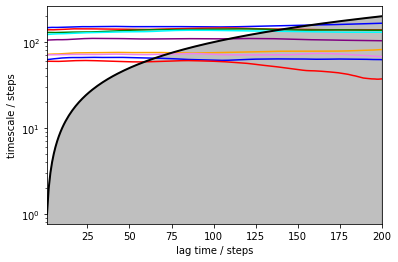

In [24]:
lagtimes = np.arange(1, 201) #output 10 at tau 1
timescales = []
for lag in lagtimes:
    estimator = dt.decomposition.VAMP(lagtime=lag, observable_transform=model)
    vamp_model = estimator.fit(data).fetch_model()
    timescales.append(vamp_model.timescales())
pyemma.plots.plot_implied_timescales((lagtimes, timescales));

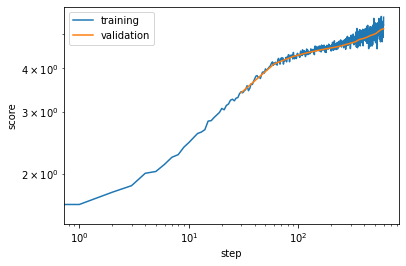

In [28]:
plt.loglog(*vampnet.train_scores.T, label='training') #output 10 at tau 50
plt.loglog(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend();

In [29]:
transformed_data_initial_10_50 = model.transform(data)

/home/ferdinand/anaconda3/envs/workshop/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


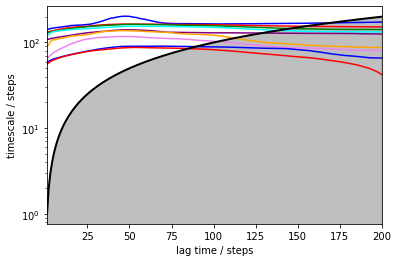

In [30]:
lagtimes = np.arange(1, 201) #output 10 at tau 50
timescales = []
for lag in lagtimes:
    estimator = dt.decomposition.VAMP(lagtime=lag, observable_transform=model)
    vamp_model = estimator.fit(data).fetch_model()
    timescales.append(vamp_model.timescales())
pyemma.plots.plot_implied_timescales((lagtimes, timescales));

In [53]:
def analyze_timescales(tau,hidden_size1,hidden_size2,hidden_size3,hidden_size4,output_size):
    # Tau, how much is the timeshift of the two datasets
    tau = tau

    # Batch size for Stochastic Gradient descent
    batch_size = 3000 

    # Which trajectory points percentage is used as validation
    val_ratio = 0.1

    # How many hidden layers the network has
    network_depth = 6 # is defined in lobe below

    # "Width" of every layer
    layer_width = 20 # is defined in lobe below

    # Learning rate used for the ADAM optimizer
    learning_rate = 1e-3 

    # How many output states the network has
    output_size = output_size

    # Iteration over the training set in the fitting process;
    # basically how many iterations our training algorithm will do
    nb_epoch = 20

    dataset = dt.data.TimeLaggedDataset.from_trajectory(lagtime=tau, data=data.astype(np.float32))

    # Number of validation data points 
    n_val = int(len(dataset)*val_ratio)
    # actual splitting of the dataset
    train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

    from deeptime.util.torch import MLP
    lobe = MLP(units=[data.shape[1], hidden_size1,hidden_size2,hidden_size3,hidden_size4, output_size], nonlinearity=nn.ReLU, output_nonlinearity=nn.Softmax)
    # here we use the retified linear unit as a nonlinearity for processing the layer outputs
    # the final output is piped though a softmax function which is 
    # a generalized logistic function which ensures positive output values 
    # -> good to interpret as a probability

    vampnet = dt.decomposition.deep.VAMPNet(lobe=lobe, learning_rate=learning_rate)
    # projects data onto dominant slow processes 

    from torch.utils.data import DataLoader

    loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)


    model = vampnet.fit(loader_train, n_epochs=nb_epoch, validation_loader=loader_val, progress=tqdm).fetch_model()

    plt.loglog(*vampnet.train_scores.T, label='training')
    plt.loglog(*vampnet.validation_scores.T, label='validation')
    plt.xlabel('step')
    plt.ylabel('score')
    plt.legend();
    plt.show()
    transformed_data = model.transform(data)


    lagtimes = np.arange(1, 201)
    timescales = []
    for lag in lagtimes:
        estimator = dt.decomposition.VAMP(lagtime=lag, observable_transform=model)
        vamp_model = estimator.fit(data).fetch_model()
        timescales.append(vamp_model.timescales())
    pyemma.plots.plot_implied_timescales((lagtimes, timescales));
    plt.show()

VAMPNet epoch:   0%|          | 0/20 [00:00<?, ?it/s]

/home/ferdinand/anaconda3/envs/workshop/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


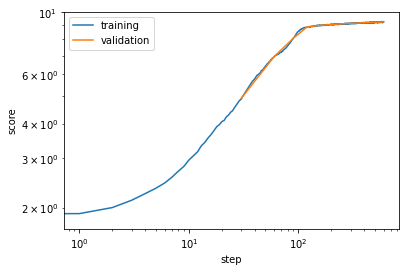

/home/ferdinand/anaconda3/envs/workshop/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


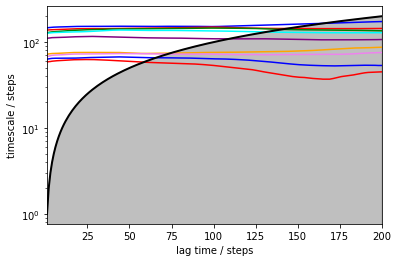

In [34]:
analyze_timescales(4,20,20,20,20,10)

## Bottleneck of variable node analysis 

In [ ]:
analyze_timescales(...)

here we conclude that we don't see the timescales of the equilibrium state. instead it starts from the first metastable state according to the next lower eigenvalue

## Correlation between distances from center to outputs of bottlenecks

### obtaining the bottleneck activations

In [47]:
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [48]:
h = model.lobe._sequential[3].register_forward_hook(getActivation('linear'))

In [49]:
model.lobe

MLP(
  (_sequential): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=10, bias=True)
    (10): Softmax(dim=None)
  )
)

In [50]:
model.transform(data)

/home/ferdinand/anaconda3/envs/workshop/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


array([[0.09120477, 0.13865972, 0.1169357 , ..., 0.08241957, 0.09442124,
        0.13527857],
       [0.09043552, 0.14014642, 0.1221373 , ..., 0.08180705, 0.08931742,
        0.13408178],
       [0.08308692, 0.1367403 , 0.12476891, ..., 0.09264705, 0.09118495,
        0.12448774],
       ...,
       [0.09683401, 0.15728106, 0.08459333, ..., 0.08091522, 0.11225937,
        0.14512728],
       [0.09261045, 0.15486877, 0.08457495, ..., 0.08578704, 0.11717129,
        0.14074765],
       [0.10078989, 0.16091377, 0.07938759, ..., 0.077499  , 0.11215376,
        0.14747027]], dtype=float32)

In [51]:
activation

{'linear': tensor([[ 0.3770, -0.1933,  0.3258,  ...,  0.5739,  0.7294, -0.0825],
         [ 0.4035, -0.1673,  0.3377,  ...,  0.5789,  0.7293,  0.0047],
         [ 0.2721, -0.1972,  0.2514,  ...,  0.5033,  0.7138,  0.0212],
         ...,
         [-0.2233, -0.4255,  0.4992,  ...,  0.8167,  1.2562, -0.8825],
         [-0.2536, -0.5077,  0.4406,  ...,  0.7811,  1.2418, -0.8282],
         [-0.2569, -0.4198,  0.5972,  ...,  0.7715,  1.3592, -0.9276]])}